In [1]:
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hf_e = h5py.File('../input/ml4sci/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
electron_data_x = hf_e.get('X')
electron_data_y = hf_e.get('y')

In [3]:
hf_p = h5py.File('../input/ml4sci/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
photon_data_x = hf_p.get('X')
photon_data_y = hf_p.get('y')

In [4]:
electron_data_x = np.asarray(electron_data_x)
electron_data_y = np.asarray(electron_data_y)

photon_data_x = np.asarray(photon_data_x)
photon_data_y = np.asarray(photon_data_y)

In [5]:
print(electron_data_x.shape)
print(photon_data_x.shape)

print(electron_data_y.shape)
print(photon_data_y.shape)

(249000, 32, 32, 2)
(249000, 32, 32, 2)
(249000,)
(249000,)


In [6]:
X = np.concatenate((electron_data_x, photon_data_x))
y = np.concatenate((electron_data_y, photon_data_y))

In [7]:
print(X.shape)
print(y.shape)

(498000, 32, 32, 2)
(498000,)


In [8]:
# X_vis = X[:5]

# fig, axes = plt.subplots(nrows=len(X_vis), ncols=2, figsize=(48, 48))
# for i in range(len(X_vis)):

#     axes[i][0].imshow(X_vis[i,:,:,0])
#     axes[i][1].imshow(X_vis[i,:,:,1])



In [9]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)
X, y = shuffle(X, y, random_state=0) #really random 

In [10]:
# mean = 0.015
# std = 0.297

In [11]:
X_train = X[:496900]
X_val = X[496900:497900]
X_test = X[497900:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(496900, 32, 32, 2)
(1000, 32, 32, 2)
(100, 32, 32, 2)


In [12]:
y_train = y[:496900]
y_val = y[496900:497900]
y_test = y[497900:]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(496900,)
(1000,)
(100,)


In [13]:
# model = CreateModel()
# model.to(Config['DEVICE'])

In [14]:
batch_size = 32
img_size = 32

In [15]:
# from sklearn.preprocessing import normalize
# normed_matrix = normalize(X, axis=1, norm='l1')

In [16]:
# X = np.linalg.norm(X, axis = 1, keepdims = True)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

# datagen = ImageDataGenerator(
#     featurewise_std_normalization=True,
# )
# datagen.fit(X_train)
# datagen.fit(X_val)
# datagen.fit(X_test)

In [18]:
import tensorflow as tf
model = tf.keras.models.Sequential([

    tf.keras.layers.Normalization(),
    tf.keras.layers.Conv2D(32, 2, padding='same', activation='relu', input_shape=(img_size, img_size, 2)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same',),
    

    tf.keras.layers.Conv2D(64, 2, padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
   

    tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  

    tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    
    
    tf.keras.layers.Dense(1, activation='sigmoid')

    
])

2022-03-20 06:17:28.290723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:17:28.382432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:17:28.383266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 06:17:28.384757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['AUC']
)

In [20]:
call_back = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [21]:
labels = [0,1]

In [22]:

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=datagen.flow(X_val, y_val,
    batch_size=batch_size),
    epochs = 200,
    callbacks = [call_back]
)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (496900, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1000, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
2022-03-20 06:17:31.819452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-03-20 06:17:36.981831: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Pas

Epoch 1/200
15529/15529 [==============================] - 137s 9ms/step - loss: 0.6158 - auc: 0.7198 - val_loss: 0.6177 - val_auc: 0.7492
Epoch 2/200
15529/15529 [==============================] - 136s 9ms/step - loss: 0.5867 - auc: 0.7553 - val_loss: 0.5822 - val_auc: 0.7693
Epoch 3/200
15529/15529 [==============================] - 140s 9ms/step - loss: 0.5791 - auc: 0.7641 - val_loss: 0.5848 - val_auc: 0.7703
Epoch 4/200
15529/15529 [==============================] - 139s 9ms/step - loss: 0.5731 - auc: 0.7704 - val_loss: 0.5882 - val_auc: 0.7657
Epoch 5/200
15529/15529 [==============================] - 141s 9ms/step - loss: 0.5699 - auc: 0.7739 - val_loss: 0.5826 - val_auc: 0.7660
Epoch 6/200
15529/15529 [==============================] - 139s 9ms/step - loss: 0.5673 - auc: 0.7766 - val_loss: 0.6065 - val_auc: 0.7537
Epoch 7/200
15529/15529 [==============================] - 140s 9ms/step - loss: 0.5653 - auc: 0.7788 - val_loss: 0.6260 - val_auc: 0.7445
Epoch 8/200
15529/15529 [==

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training & validation loss')

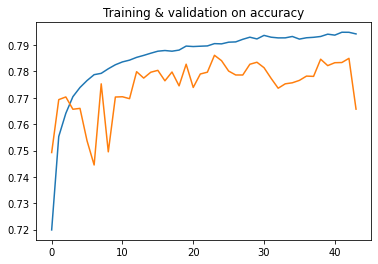

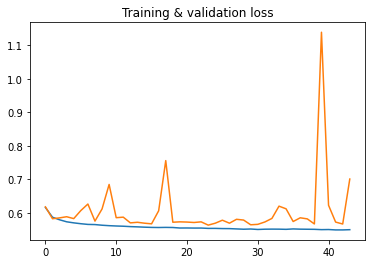

In [24]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & validation on accuracy')
plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training & validation loss')